In [1]:
import numpy as np
import tensorflow as tf
import binvox_rw
import matplotlib.pyplot as plt
from pathlib import Path
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

In [2]:
def center(voxin):
    f = np.squeeze(np.max(voxin, axis=(2, 1)))
    s = np.squeeze(np.max(voxin, axis=(2, 0)))
    t = np.squeeze(np.max(voxin, axis=(1, 0)))

    nzf = np.sum(f == 0) 
    nzs = np.sum(s == 0)
    nzt = np.sum(t == 0)

    i_f = np.argmax(f)
    l_f = np.sum(f > 0)
    i_s = np.argmax(s)
    l_s = np.sum(s > 0)
    i_t = np.argmax(t)
    l_t = np.sum(t > 0)

    zfl = np.floor(nzf/2.0).astype(int)
    zfr = nzf - zfl
    zsl = np.floor(nzs/2.0).astype(int)
    zsr = nzs - zsl
    ztl = np.floor(nzt/2.0).astype(int)
    ztr = nzt - ztl  

    voxout = np.zeros_like(voxin)
    voxout[zfl:128-zfr, zsl:128-zsr, ztl:128-ztr] = voxin[i_f:i_f+l_f, i_s:i_s+l_s, i_t:i_t+l_t,]
    return voxout

In [3]:
class voxel_gen(Sequence):
    def __init__(self, y_set, batch_size=32, dim_image=(512, 512, 3), dim_voxel=(128, 128, 128)):
        self.y = y_set # path for each dataset : models/models-binvox-solid
        self.batch_size = batch_size
        self.dim_voxel = dim_voxel
        self.dim_image = dim_image

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.y) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        y_set_temp = self.y[index*self.batch_size:(index+1)*self.batch_size]
        #x_set_temp = self.x[index*self.batch_size:(index+1)*self.batch_size]
        X, Y = self.__data_generation(y_set_temp)
        return [X, Y]
    
    def __data_generation(self, y_set_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X0 = np.empty((self.batch_size, *self.dim_image))
        X1 = np.empty((self.batch_size, *self.dim_image))
        X2 = np.empty((self.batch_size, *self.dim_image))
        X3 = np.empty((self.batch_size, *self.dim_image))
        Y = np.empty((self.batch_size, *self.dim_voxel, 1))

        for i, stem in enumerate(y_set_temp):
            view0 = f"models/models-screenshots/view0/data/{stem}-00.png"
            view1 = f"models/models-screenshots/view1/data/{stem}-01.png"
            view2 = f"models/models-screenshots/view2/data/{stem}-02.png"
            view3 = f"models/models-screenshots/view3/data/{stem}-03.png"
            X0[i,] = np.array(Image.open(view0))[:, :, 0:3] / 255.
            X1[i,] = np.array(Image.open(view1))[:, :, 0:3] / 255.
            X2[i,] = np.array(Image.open(view2))[:, :, 0:3] / 255.
            X3[i,] = np.array(Image.open(view3))[:, :, 0:3] / 255.
            vox = f"models/models-binvox-solid/data/{stem}.binvox"
            with open(str(vox), 'rb') as f:
                model = binvox_rw.read_as_3d_array(f)
            Y[i,] = np.expand_dims(center(model.data), axis=-1) * 1
    
        return [[X0, X1, X2, X3], Y]

In [4]:
def customGen(batch_size=32):
    voxels = Path("models/models-binvox-solid/data")
    fvoxels = [f.stem for f in voxels.iterdir() if f.is_file()]
    out = voxel_gen(fvoxels, batch_size)
    while True:
        for x, y in out:
            yield [x, y]

In [5]:
gen1 = customGen(1)

(1, 512, 512, 3) (1, 512, 512, 3) (1, 512, 512, 3) (1, 512, 512, 3)
00001
float64
float64


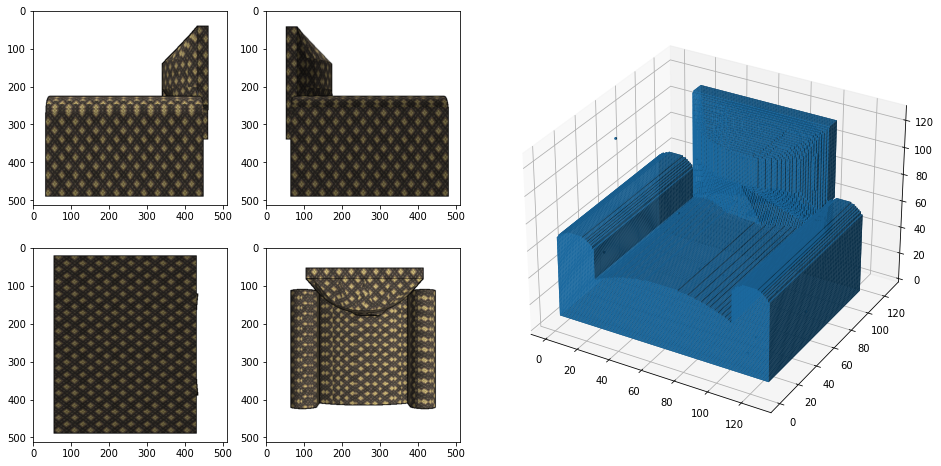

(1, 512, 512, 3) (1, 512, 512, 3) (1, 512, 512, 3) (1, 512, 512, 3)
00002
float64
float64


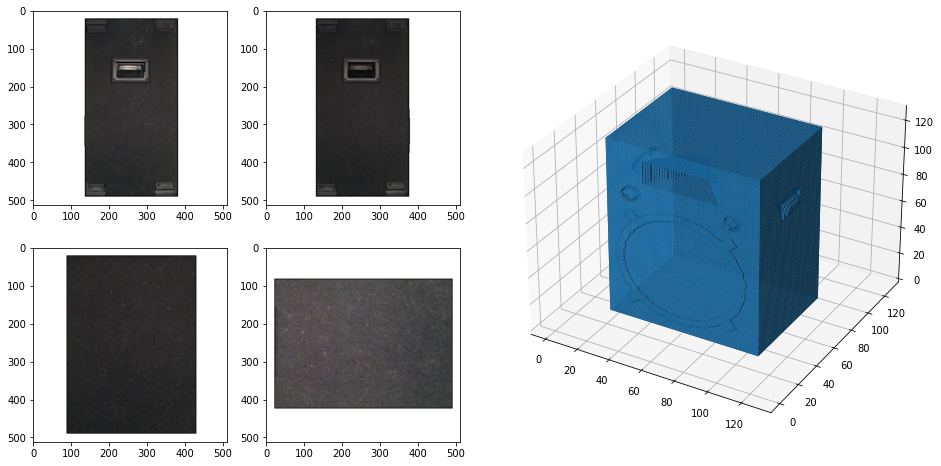

In [6]:
voxels = Path("models/models-binvox-solid/data")
fvoxels = [f for f in voxels.iterdir() if f.is_file()]
count = -1
for X, y in gen1:
    count += 1 
    if count<2:
        print(X[0].shape,X[1].shape,X[2].shape,X[3].shape)
        print(fvoxels[count].stem)
        print(X[0].dtype)
        print(y.dtype)
        fig = plt.figure(figsize=(16, 8))
        ax1 = plt.subplot2grid((2, 4), (0, 0))
        ax2 = plt.subplot2grid((2, 4), (0, 1))
        ax3 = plt.subplot2grid((2, 4), (1, 0))
        ax4 = plt.subplot2grid((2, 4), (1, 1))
        ax5 = plt.subplot2grid((2, 4), (0, 2), colspan=2, rowspan=2, projection='3d')
        ax1.imshow(np.squeeze(X[0]))
        ax2.imshow(np.squeeze(X[1]))
        ax3.imshow(np.squeeze(X[2]))
        ax4.imshow(np.squeeze(X[3]))
        ax5.voxels(np.squeeze(y))
        plt.show()
    else:
        break

In [ ]:
import skimage.measure
from skimage.measure import block_reduce
voxels = Path("models/models-binvox-solid/data/00001.binvox")
with open(voxels, 'rb') as f:
    model = binvox_rw.read_as_3d_array(f)
# model.dims 
#model.data
image=(np.array(model.data))*1
print(image.shape)
#.reshape(model.dims)+0
k=skimage.measure.block_reduce(image, (2,2,2), np.max)
print(k.shape)